In [1]:
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git' > /dev/null

  Running command git clone --filter=blob:none -q https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-3e_ma8w1


In [3]:
import os
import detectron2
from pathlib import Path
import random, cv2, os
import matplotlib.pyplot as plt
import numpy as np
import pycocotools.mask as mask_util
import torch

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.utils.logger import setup_logger
from detectron2.evaluation.evaluator import DatasetEvaluator
setup_logger()

<_Logger detectron2 (DEBUG)>

In [4]:
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader, build_detection_train_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
import pandas as pd

In [5]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
def set_random(n):
    random.seed(n)
    np.random.seed(n)
    torch.manual_seed(n)
    torch.cuda.manual_seed(n)
    torch.cuda.manual_seed_all(n)
    torch.backends.cudnn.deterministic = True
    os.environ['PYTHONHASHSEED'] = str(n)
    
set_random(42)

In [6]:
!nvidia-smi --query-gpu=gpu_name,driver_version,memory.total --format=csv

name, driver_version, memory.total [MiB]
Tesla P100-PCIE-16GB, 450.119.04, 16280 MiB


In [7]:
data_path = '../input/sartorius-cell-instance-segmentation'
train_ann = "../input/annotations-sartorius/annotations_train.json"
val_ann = "../input/annotations-sartorius/annotations_val.json"

ROOT = Path(data_path)

In [8]:
cfg = get_cfg()
cfg.INPUT.MASK_FORMAT='bitmask'
register_coco_instances('sartorius_train',{},train_ann, ROOT)
register_coco_instances('sartorius_val',{},val_ann, ROOT)
metadata = MetadataCatalog.get('sartorius_train')
train_ds = DatasetCatalog.get('sartorius_train')
val_ds = DatasetCatalog.get('sartorius_val')

[12/28 01:07:46 d2.data.datasets.coco]: Loaded 515 images in COCO format from ../input/annotations-sartorius/annotations_train.json
[12/28 01:07:46 d2.data.datasets.coco]: Loaded 61 images in COCO format from ../input/annotations-sartorius/annotations_val.json


<h2 class="list-group-item list-group-item-action active" data-toggle="list" style='background:orange; border:0; color:white' role="tab" aria-controls="home"><center>Visualize the data</center></h2>

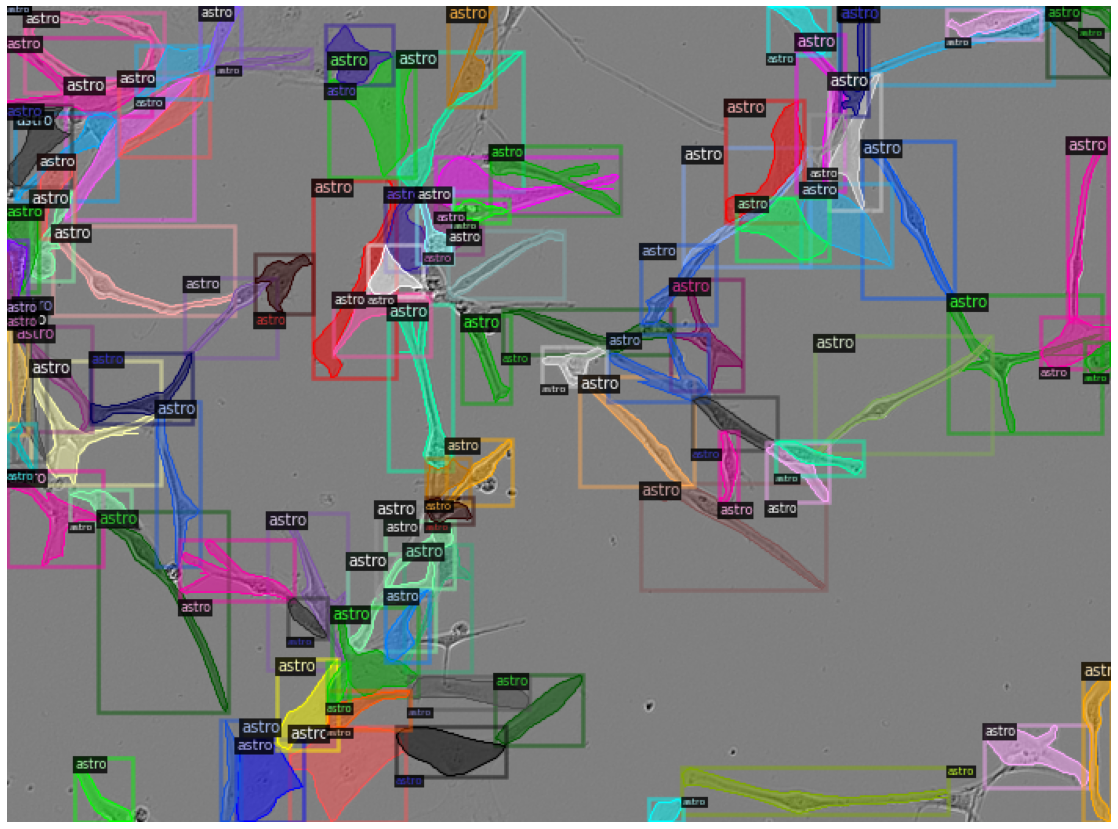

In [9]:
d = train_ds[1]
img = cv2.imread(d["file_name"])
visualizer = Visualizer(img[:, :, ::-1], metadata=metadata)
out = visualizer.draw_dataset_dict(d)
plt.figure(figsize = (20,15))
plt.imshow(out.get_image()[:, :, ::-1])
plt.axis('off')
plt.show()

<h2 class="list-group-item list-group-item-action active" data-toggle="list" style='background:orange; border:0; color:white' role="tab" aria-controls="home"><center>EVALUATOR</center></h2>

Generates lines like this in the training output: [10/27 18:31:26 d2.evaluation.testing]: copypaste: MaP IoU=0.2192638391201311

See here for definition: https://www.kaggle.com/c/sartorius-cell-instance-segmentation/overview/evaluation

In [10]:
# Taken from https://www.kaggle.com/theoviel/competition-metric-map-iou
def precision_at(threshold, iou):
    matches = iou > threshold
    true_positives = np.sum(matches, axis=1) == 1  # Correct objects
    false_positives = np.sum(matches, axis=0) == 0  # Missed objects
    false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
    return np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)

def score(pred, targ):
    pred_masks = pred['instances'].pred_masks.cpu().numpy()
    enc_preds = [mask_util.encode(np.asarray(p, order='F')) for p in pred_masks]
    enc_targs = list(map(lambda x:x['segmentation'], targ))
    ious = mask_util.iou(enc_preds, enc_targs, [0]*len(enc_targs))
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, ious)
        p = tp / (tp + fp + fn)
        prec.append(p)
    return np.mean(prec)

In [12]:
class MAPIOUEvaluator(DatasetEvaluator):
    def __init__(self, dataset_name):
        dataset_dicts = DatasetCatalog.get(dataset_name)
        self.annotations_cache = {item['image_id']:item['annotations'] for item in dataset_dicts}
            
    def reset(self):
        self.scores = []

    def process(self, inputs, outputs):
        for inp, out in zip(inputs, outputs):
            if len(out['instances']) == 0:
                self.scores.append(0)    
            else:
                targ = self.annotations_cache[inp['image_id']]
                self.scores.append(score(out, targ))

    def evaluate(self):
        return {"MaP IoU": np.mean(self.scores)}

class Trainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        return MAPIOUEvaluator(dataset_name)

In [14]:
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("sartorius_train",)
cfg.DATASETS.TEST = ("sartorius_val",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2 #(2 is per defaults)
cfg.SOLVER.BASE_LR = 0.0005 
cfg.SOLVER.MAX_ITER = 10000  #Maximum of iterations  
cfg.SOLVER.STEPS = (7000, 9000)    #At which point to change the LR 0.25,0.5    
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64   
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3  
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = .5
cfg.TEST.EVAL_PERIOD = len(DatasetCatalog.get('sartorius_train')) // cfg.SOLVER.IMS_PER_BATCH  # Once per epoch
cfg.SOLVER.WARMUP_ITERS = 10 #How many iterations to go from 0 to reach base LR

#cfg.SOLVER.STEPS = (500, 1000) #At which point to change the LR 0.25,0.5

cfg.SOLVER.CHECKPOINT_PERIOD = len(DatasetCatalog.get('sartorius_train')) // cfg.SOLVER.IMS_PER_BATCH  # Once per epoch

cfg.SOLVER.MOMENTUM = 0.9
cfg.SOLVER.WEIGHT_DECAY = 0.0005
cfg.SOLVER.GAMMA = 0.1



[12/28 01:09:23 d2.data.datasets.coco]: Loaded 515 images in COCO format from ../input/annotations-sartorius/annotations_train.json
[12/28 01:09:24 d2.data.datasets.coco]: Loaded 515 images in COCO format from ../input/annotations-sartorius/annotations_train.json


In [15]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = Trainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[12/28 01:09:35 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f10217.pkl: 178MB [00:17, 10.1MB/s]                              


[12/28 01:09:58 d2.engine.train_loop]: Starting training from iteration 0


/opt/conda/lib/python3.7/site-packages/detectron2/data/detection_utils.py:433: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /usr/local/src/pytorch/torch/csrc/utils/tensor_numpy.cpp:174.)
  torch.stack([torch.from_numpy(np.ascontiguousarray(x)) for x in masks])
/opt/conda/lib/python3.7/site-packages/detectron2/data/detection_utils.py:433: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it 

[12/28 01:10:28 d2.utils.events]:  eta: 2:18:29  iter: 19  total_loss: 2.873  loss_cls: 0.9501  loss_box_reg: 0.4696  loss_mask: 0.6753  loss_rpn_cls: 0.4225  loss_rpn_loc: 0.2642  time: 1.1498  data_time: 0.4849  lr: 0.0005  max_mem: 3946M
[12/28 01:11:00 d2.utils.events]:  eta: 2:19:00  iter: 39  total_loss: 2.522  loss_cls: 0.7485  loss_box_reg: 0.6091  loss_mask: 0.5795  loss_rpn_cls: 0.2751  loss_rpn_loc: 0.2986  time: 1.3873  data_time: 0.8882  lr: 0.0005  max_mem: 4961M
[12/28 01:11:37 d2.utils.events]:  eta: 2:18:19  iter: 59  total_loss: 2.277  loss_cls: 0.6653  loss_box_reg: 0.6051  loss_mask: 0.4747  loss_rpn_cls: 0.1988  loss_rpn_loc: 0.2761  time: 1.5532  data_time: 1.2066  lr: 0.0005  max_mem: 5360M
[12/28 01:12:12 d2.utils.events]:  eta: 2:22:55  iter: 79  total_loss: 2.198  loss_cls: 0.6855  loss_box_reg: 0.6323  loss_mask: 0.4286  loss_rpn_cls: 0.1875  loss_rpn_loc: 0.282  time: 1.6075  data_time: 1.0659  lr: 0.0005  max_mem: 5360M
[12/28 01:12:37 d2.utils.events]:  et

[12/28 05:43:35 d2.data.datasets.coco]: Loaded 61 images in COCO format from ../input/annotations-sartorius/annotations_val.json


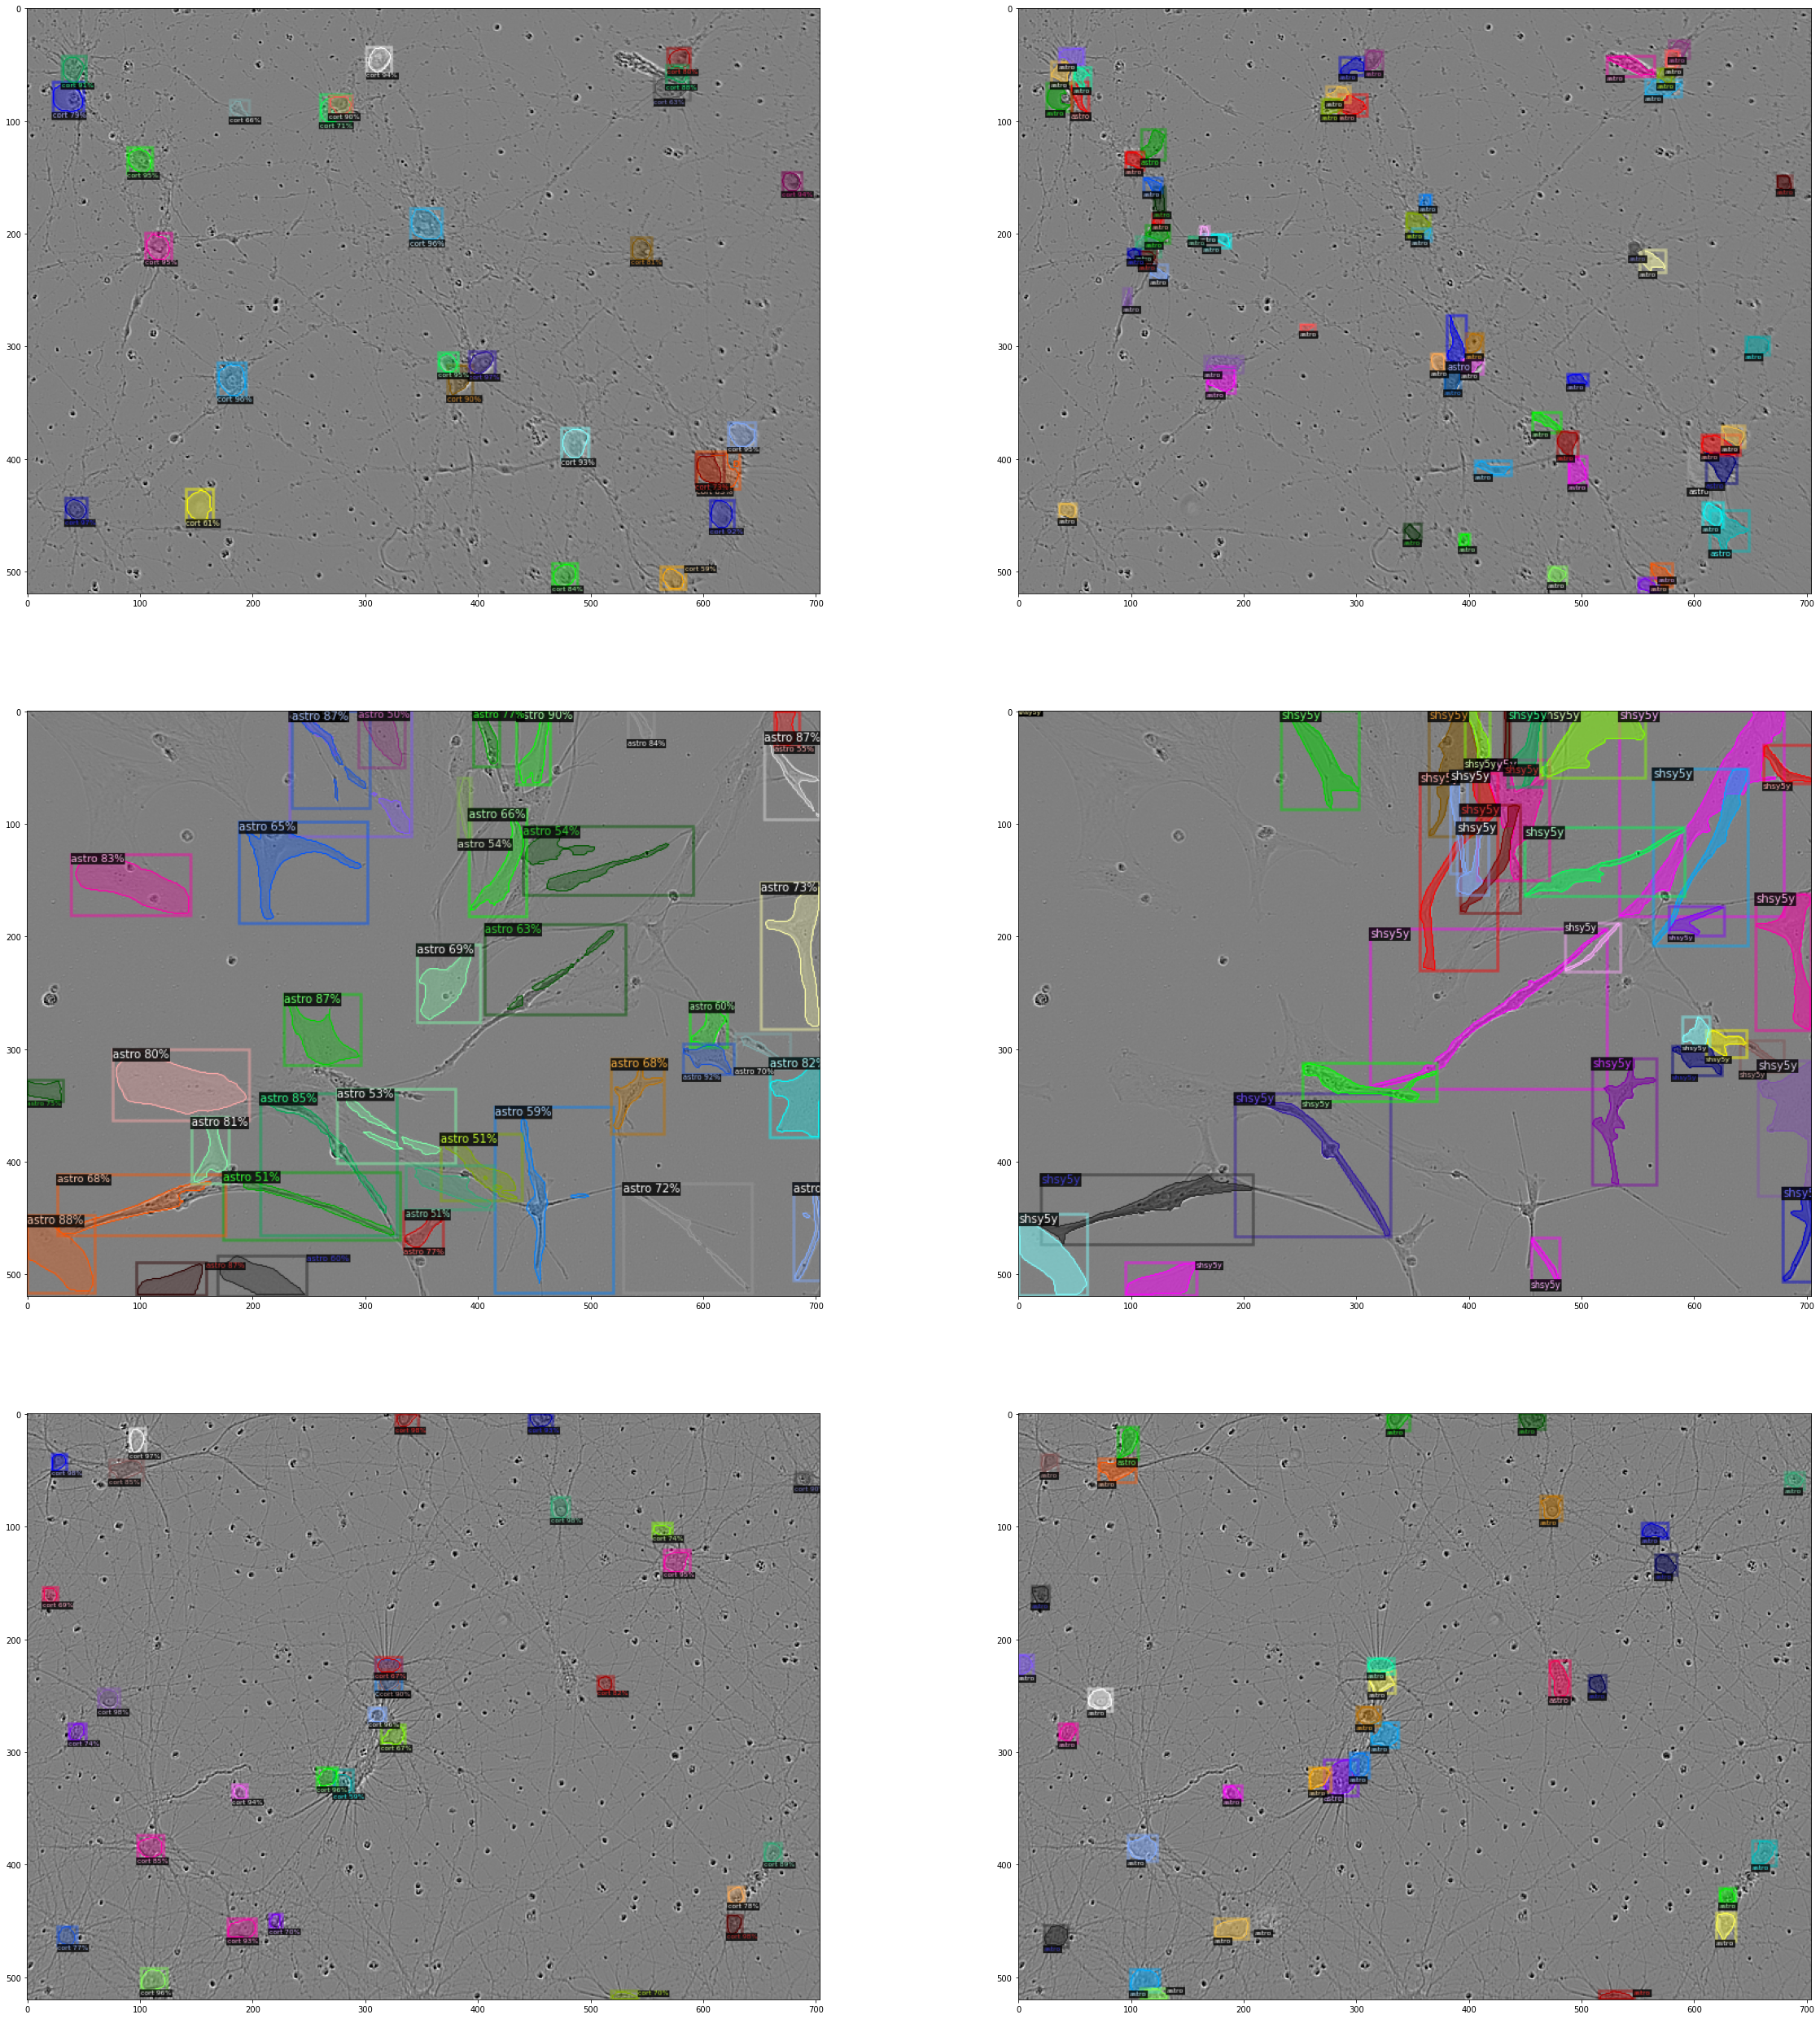

In [19]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold
predictor = DefaultPredictor(cfg)
dataset_dicts = DatasetCatalog.get('sartorius_val')
outs = []
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata = MetadataCatalog.get('sartorius_train'), 
                    
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out_pred = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    visualizer = Visualizer(im[:, :, ::-1], metadata=MetadataCatalog.get('sartorius_train'))
    out_target = visualizer.draw_dataset_dict(d)
    outs.append(out_pred)
    outs.append(out_target)
_,axs = plt.subplots(len(outs)//2,2,figsize=(40,45))
for ax, out in zip(axs.reshape(-1), outs):
    ax.imshow(out.get_image()[:, :, ::-1])

# EVALUATOR

For some datasets evaluation is already implemented in detectron2

For instance, many kinds of Average Precision are calculated in COCO evaluator

COCOEvaluator calculates AP with IoU from 0.50 to 0.95


In [20]:
evaluator = COCOEvaluator('sartorius_val', cfg, False, output_dir="./output/")
#cfg.MODEL.WEIGHTS="../input/detectron2cell/output/model_final.pth"
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.4   # set a custom testing threshold
#cfg.INPUT.MASK_FORMAT='polygon'
val_loader = build_detection_test_loader(cfg, 'sartorius_val')
inference_on_dataset(trainer.model, val_loader, evaluator)

WARNING [12/28 05:45:23 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[12/28 05:45:23 d2.data.datasets.coco]: Loaded 61 images in COCO format from ../input/annotations-sartorius/annotations_val.json
[12/28 05:45:23 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[12/28 05:45:23 d2.data.common]: Serializing 61 elements to byte tensors and concatenating them all ...
[12/28 05:45:23 d2.data.common]: Serialized dataset takes 0.88 MiB
[12/28 05:45:23 d2.evaluation.evaluator]: Start inference on 61 batches
[12/28 05:45:25 d2.evaluation.evaluator]: Inference done 11/61. Dataloading: 0.0015 s/iter. Inference: 0.1266 s/iter. Eval: 0.0388 s/iter. Total: 0.1668 s/iter. ETA=0:00:08
[12/28 05:45:30 d2.evaluation.evaluator]: Inference done 41/61. Dataloading: 0.0020 s/iter. Inference: 0.1

OrderedDict([('bbox',
              {'AP': 0.0,
               'AP50': 0.0,
               'AP75': 0.0,
               'APs': 0.0,
               'APm': 0.0,
               'APl': nan,
               'AP-astro': 0.0,
               'AP-cort': 0.0,
               'AP-shsy5y': 0.0}),
             ('segm',
              {'AP': 0.0,
               'AP50': 0.0,
               'AP75': 0.0,
               'APs': 0.0,
               'APm': 0.0,
               'APl': nan,
               'AP-astro': 0.0,
               'AP-cort': 0.0,
               'AP-shsy5y': 0.0})])

In [21]:
metrics_df = pd.read_json("./output/metrics.json", orient="records", lines=True)
mdf = metrics_df.sort_values("iteration")

<h2 class="list-group-item list-group-item-action active" data-toggle="list" style='background:orange; border:0; color:white' role="tab" aria-controls="home"><center>Plot losses</center></h2>

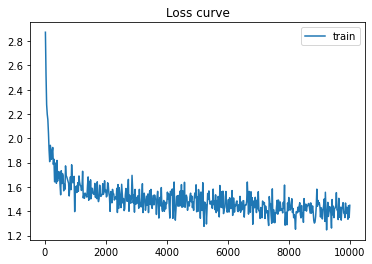

In [22]:
# 1. Loss curve
fig, ax = plt.subplots()

mdf1 = mdf[~mdf["total_loss"].isna()]
ax.plot(mdf1["iteration"], mdf1["total_loss"], c="C0", label="train")
if "validation_loss" in mdf.columns:
    mdf2 = mdf[~mdf["validation_loss"].isna()]
    ax.plot(mdf2["iteration"], mdf2["validation_loss"], c="C1", label="validation")

# ax.set_ylim([0, 0.5])
ax.legend()
ax.set_title("Loss curve")
plt.show()

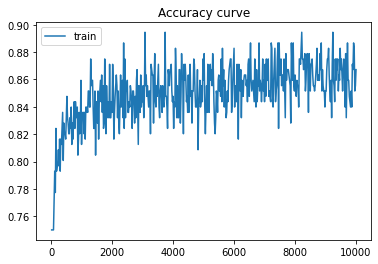

In [23]:
# 1. Accuracy curve
fig, ax = plt.subplots()

mdf1 = mdf[~mdf["fast_rcnn/cls_accuracy"].isna()]
ax.plot(mdf1["iteration"], mdf1["fast_rcnn/cls_accuracy"], c="C0", label="train")
# ax.set_ylim([0, 0.5])
ax.legend()
ax.set_title("Accuracy curve")
plt.show()

# PREDICTOR

In [24]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.4   # set a custom testing threshold
predictor = DefaultPredictor(cfg)
dataset_dicts = DatasetCatalog.get('sartorius_val')

[12/28 05:45:35 d2.data.datasets.coco]: Loaded 61 images in COCO format from ../input/annotations-sartorius/annotations_val.json


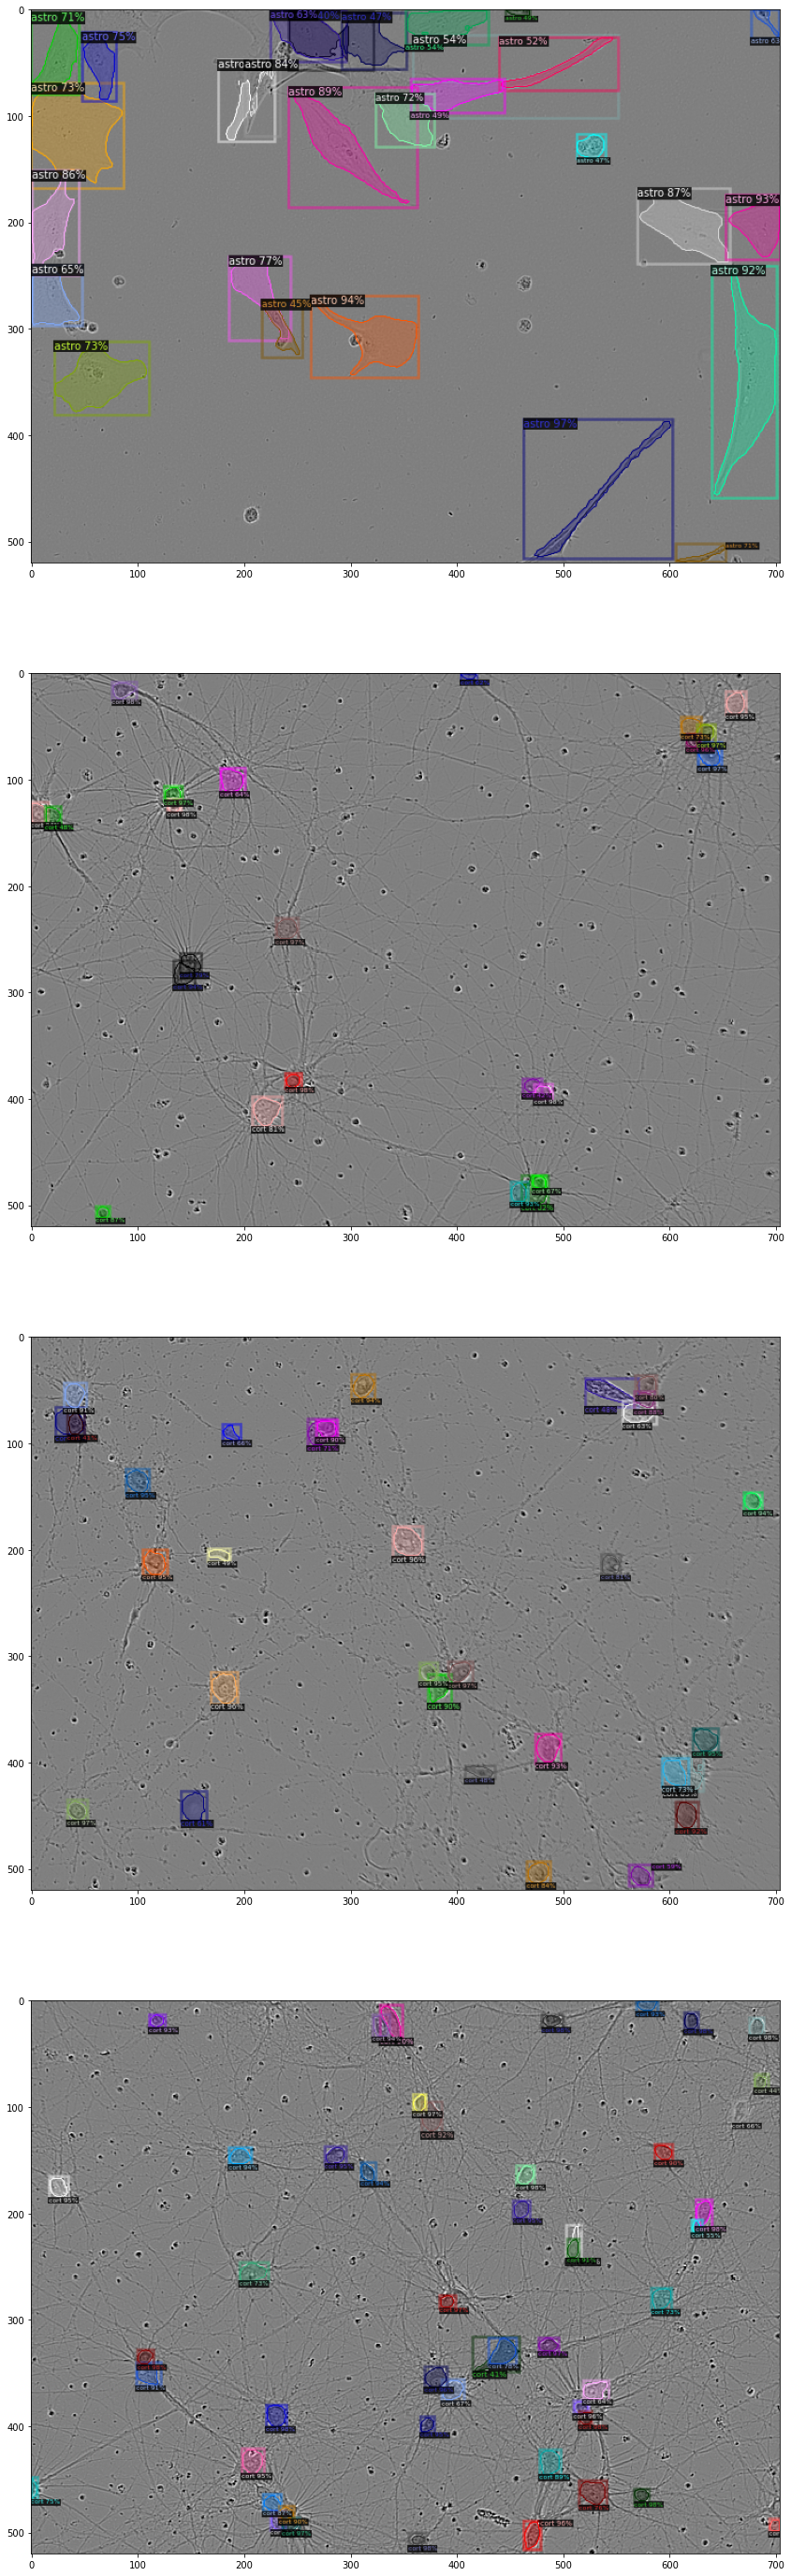

In [25]:
fig, ax = plt.subplots(4, 1, figsize =(20,50))
indices=[ax[0],ax[1],ax[2],ax[3] ]
i=-1
for d in random.sample(val_ds, 4):
    i=i+1    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=metadata, 
                   scale=1, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    indices[i].grid(False)
    indices[i].imshow(out.get_image()[:, :, ::-1])

In [18]:
print('ii')

ii
